# Coordinate transformation of correlated images

This example shows how to apply a coordinate transformation previously obtained by correlating 
a 3D (such as confocal) and a 2D (such as ion beam) image to transform the correlated
images. In this way, the confocal image is transformed to the ion beam coordinate
system, so that the transformed confocal image "looks like" the ion beam image, or
the ion beam image is transformed to the confocal system.

The transformation is read from the output files previously generated by running 3DCT.
To make it easier to visualize the transformation, the images used to establish the 
correlation were artificially generated.

The image transformations shown here are performed using Pyto package.

In [1]:
import sys
import pickle
from copy import copy, deepcopy

import numpy as np
import tifffile as tf

import pyto
from pyto.geometry.rigid_3d import Rigid3D

# matplotlib 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# for convenience
%load_ext autoreload
%autoreload 2
%autosave 0
sys.version

Autosave disabled


'3.7.3 (default, Oct  7 2019, 12:56:13) \n[GCC 8.3.0]'

## Small example - Transformation from 3DCT

### Read images, markers and transform parameters

In [2]:
# File names
confocal_file_name = 'small_cf.tif'
ion_beam_file_name = 'small_ib.tif'
results_file_name = '2020-04-24_15-03-41_correlation.txt'

In [3]:
# Rad images and adjust axes
cf_data = tf.imread(confocal_file_name).transpose()
ib_data = tf.imread(ion_beam_file_name)
if len(ib_data.shape) == 3:
    ib_data = ib_data[:,:,0]
ib_data = ib_data.transpose()

In [4]:
# read marker positions
results = np.loadtxt(results_file_name)
cf_markers = results[:,0:3]
cf_markers_transformed = results[:,3:6]
ib_markers = results[:,6:8]
transform_error = results[:,8:10]

In [5]:
# Read parameters from 3DCT results

with open(results_file_name, 'r') as results_fd:
    for line in results_fd:
        if line.startswith('#   - rotation'):
            phi, psi, theta = np.fromstring(line.split(': [')[1].split(']')[0], sep=',')
            continue
        if line.startswith('#   - scale'):
            scale = float(line.split('= ')[1])
            continue
        if line.startswith('#   - translation for rotation around [0,0,0]'):
            trans = np.fromstring(line.split('= [')[1].split(']')[0], sep=',')
            continue
        if line.startswith('#   - translation for rotation around'):
            origin = np.fromstring(line.split('[')[1].split(']')[0], sep=',')
            trans_or = np.fromstring(line.split('= [')[1].split(']')[0], sep=',')
            break

print("Please check that the following parameters are the same as those in the 3DCT results file:")
print("phi, theta, psi = {}".format((phi, theta, psi)))
print("scale = {}".format(scale))
print("translation around [0, 0, 0] = {}".format(trans))
print("translation around {} = {}".format(origin, trans_or))

Please check that the following parameters are the same as those in the 3DCT results file:
phi, theta, psi = (-143.723, 44.996, 115.579)
scale = 0.5
translation around [0, 0, 0] = [-15.361  21.287   0.   ]
translation around [55. 55. 55.] = [  1.75    8.594 -35.247]


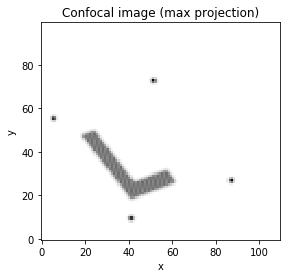

In [6]:
# show max projection confocal
plt.imshow(cf_data.max(axis=2).transpose(), cmap='Greys', origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Confocal image (max projection)');

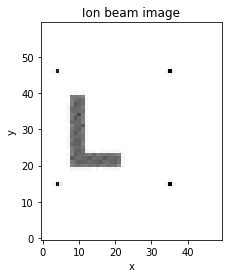

In [7]:
# Show ion beam image
plt.imshow(ib_data.transpose(), cmap='Greys', origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ion beam image');

### Transform confocal image to ion beam system

In [8]:
# Make transformation from confocal to ion beam (based on 3DCT correlation results)
euler_rad = np.array([phi, theta, psi]) * np.pi / 180
q = Rigid3D.make_r_euler(angles=euler_rad)
tdct = Rigid3D(q=q, scale=scale, d=trans)

# reposition so that transformed markers z > 0
cf_markers_tf = tdct.transform(x=cf_markers, xy_axes='point_dim')
tdct_z = deepcopy(tdct)
tdct_z.d[2] += -np.floor(cf_markers_tf[:,2]).min()
tdct_z.transform(x=cf_markers, xy_axes='point_dim');

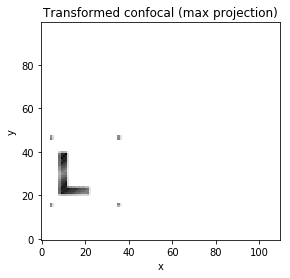

In [9]:
# Transform confocal image
cf_data_tf = tdct_z.transformArray(array=cf_data)
plt.imshow(cf_data_tf.max(axis=2).transpose(), cmap='Greys', origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Transformed confocal (max projection)");

Transformed confocal marker coordinates: 
[[45.43334198  5.61596837  0.36918178]
 [14.61826914  5.58839888  1.39585146]
 [14.49177391 36.5618814   3.5739021 ]
 [45.56801854 36.66215395  2.37929325]]


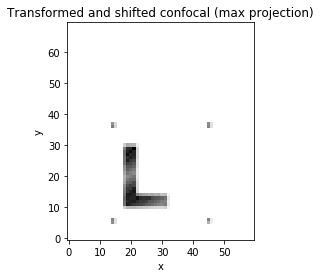

In [10]:
# Transform confocal image with position adjustments

# Usage:
#  - Run once with arbitrary shifts and shape
#  - Adjust shifts so that all transformed marker coordinates are >0
#  - Adjust shape (x, y and z) so that x, y and z coordinates are smaller
#    than the corresponding shape 
#  - At this point all markers should be visible on the transformed image
#  - Furher adjust shifts and shape if other parts of the image
#    need to be shown on the transformed image

# set shift (reposition) for the transformed image
cf_data_tf_shift = [10, -10, 0]

# set shape of transformed image
cf_data_tf_shape = [60,70,30]

# reposition
tdct_local = deepcopy(tdct)
tdct_local.d = tdct_z.d + cf_data_tf_shift

# transform confocal markers to ion beam system
cf_markers_tf_local = tdct_local.transform(x=cf_markers, xy_axes='point_dim')
print("Transformed confocal marker coordinates: \n{}".format(cf_markers_tf_local))

# transform image
cf_data_tf = tdct_local.transformArray(array=cf_data, shape=cf_data_tf_shape)
plt.imshow(cf_data_tf.max(axis=2).transpose(), cmap='Greys', origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Transformed and shifted confocal (max projection)");

In [11]:
# Save transformed image in tiff format

# transformed image name
cf_tf_file_name = 'small_cf_transformed.tif'

# image data
data = cf_data_tf

# pixel size in um
pixel_um = 0.16

# write tiff
cf_meta = {"PixelSize": str(pixel_um), "FocusStepSize": str(pixel_um)}
cf_res = (10000/pixel_um, 10000/pixel_um, 'CENTIMETER')  
tf.imwrite(
    cf_tf_file_name, np.swapaxes(data, 0, 2), metadata=cf_meta, resolution=cf_res)

In [12]:
# Save transformed image in mrc format

# transformed image name
cf_tf_file_name = 'small_cf_transformed.mrc'

# image data
data = cf_data_tf

# pixel size in um
pixel_um = 0.16

# write mrc
cf_tf_image = pyto.core.Image(data=data)
cf_tf_image.write(file=cf_tf_file_name, pixel=1000*pixel_um)

<_io.BufferedWriter name='small_cf_transformed.mrc'>

Parameters of the transformation around the specified center:
phi, theta, psi = (-143.723, 44.996, 115.57899999999997)
scale = 0.5
translation around (55, 50, 45) = [-29.59220279 -17.37716601 -45.84398503]


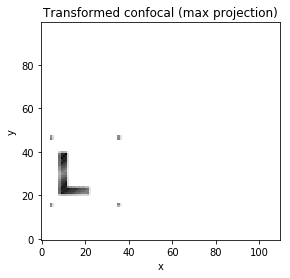

In [14]:
# Optional: Transform confocal image where the transformation is
# defined around the specified center.

# Note: The translation parameters shown here are different form 
# those in the corelation results file, because in the latter case
# only rotation center is shifted, but scaling center remains at
# 0 (coordinate syatem center), while here both rotation and scaling
# centers are shifted.

# specify coordinates of the center
center = (55, 50, 45)

# make transformation and transform markers
tdct_or = tdct.shift_center(center=center)
cf_markers_tf_or = tdct_or.transform(x=cf_markers, center=center, xy_axes='point_dim')

# reposition so that transformed markers z > 0
tdct_or_z = deepcopy(tdct_or)
tdct_or_z.d[2] += -np.floor(cf_markers_tf_or[:,2]).min()

tdct_or_z.transform(x=cf_markers, xy_axes='point_dim')
print("Parameters of the transformation around the specified center:")
(phi, theta, psi) = tdct_or_z.extract_euler(r=tdct_or_z.q) * 180 / np.pi
print("phi, theta, psi = {}".format((phi, theta, psi)))
print("scale = {}".format(tdct_or_z.s_scalar))
print("translation around {} = {}".format(center, tdct_or_z.d))

# Transform confocal image and show max projection 
cf_data_tf = tdct_or_z.transformArray(array=cf_data, center=center)
plt.imshow(cf_data_tf.max(axis=2).transpose(), cmap='Greys', origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Transformed confocal (max projection)");

### Transform ion beam image to confocal system

In [15]:
# Make transformation from ion beam to confocal image
tdct_inverse = tdct.inverse()

In [16]:
# Convert ion beam marker positions to 3D 
ib_markers_3d = np.concatenate((ib_markers, np.zeros((ib_markers.shape[0],1))), axis=1)

In [17]:
# Convert ion beam image to 3D 

# Set the z-position where the old (2D) ion beam image is 
# located within the new (3D) image. This postion shpould be away from 0  
ib_z_position = 5

# convert
ib_data_3d = np.zeros((ib_data.shape[0], ib_data.shape[1], 2*ib_z_position), dtype=ib_data.dtype)
ib_data_3d[:,:,ib_z_position] = ib_data

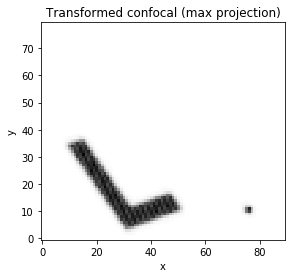

In [18]:
# Transform ion beam image and show max projection 

# set shape of transformed image
ib_data_tf_shape = [90,80,70]

# transform
ib_data_tf = tdct_inverse.transformArray(array=ib_data_3d, shape=ib_data_tf_shape)
plt.imshow(ib_data_tf.max(axis=2).transpose(), cmap='Greys', origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Transformed confocal (max projection)");

Transformed ion beam marker coordinates: 
[[100.04163704  47.46071089  61.4274567 ]
 [ 55.12025366  31.43912628  21.93740045]
 [ 21.28094031  79.7265603   40.8400719 ]
 [ 66.07116356  95.9353055   80.40339432]]


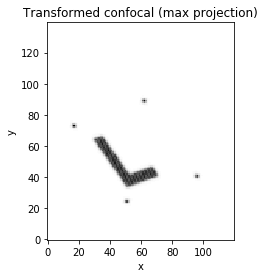

In [19]:
# Transform ion beam image with position adjustments

# Usage:
#  - Run once with arbitrary shifts and shape
#  - Adjust shifts so that all transformed marker coordinates are >0
#  - Adjust shape (x, y and z) so that x, y and z coordinates are smaller
#    than the corresponding shape 
#  - At this point all markers should be visible on the transformed image
#  - Furher adjust shifts and shape if other parts of the image
#    need to be shown on the transformed image

# set shift (reposition) for the transformed image
ib_data_tf_shift = [20, 30, 0]

# set shape of transformed image
ib_data_tf_shape = [120,140,100]

# reposition
tdct_inverse_local = deepcopy(tdct_inverse)
tdct_inverse_local.d = tdct_inverse.d + ib_data_tf_shift

# transform ion beam markers markers back to confocal system
ib_markers_tf_local = tdct_inverse_local.transform(x=ib_markers_3d, xy_axes='point_dim')
print("Transformed ion beam marker coordinates: \n{}".format(ib_markers_tf_local))

# transform image
ib_data_tf = tdct_inverse_local.transformArray(array=ib_data_3d, shape=ib_data_tf_shape)
plt.imshow(ib_data_tf.max(axis=2).transpose(), cmap='Greys', origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Transformed confocal (max projection)");

In [20]:
# Save transformed ion beam image in tiff format

# transformed image name
cf_tf_file_name = 'small_ib_transformed.tif'

# image data
data = ib_data_tf

# pixel size in um
pixel_um = 0.25

# write tiff
cf_meta = {"PixelSize": str(pixel_um), "FocusStepSize": str(pixel_um)}
cf_res = (10000/pixel_um, 10000/pixel_um, 'CENTIMETER')  
tf.imwrite(
    cf_tf_file_name, np.swapaxes(data, 0, 2), metadata=cf_meta, resolution=cf_res)

In [21]:
# Save transformed ion beam image in mrc format

# transformed image name
cf_tf_file_name = 'small_ib_transformed.mrc'

# image data
data = ib_data_tf

# pixel size in um
pixel_um = 0.25

# write mrc
cf_tf_image = pyto.core.Image(data=data)
cf_tf_image.write(file=cf_tf_file_name, pixel=1000*pixel_um, dataType='int16')

<_io.BufferedWriter name='small_ib_transformed.mrc'>